# [SITCOMTN-XXX] - M1M3 - analyze position and rotation stability throughout a tracking period

2023-12-14 Laura

This notebook evaluates displacements of M1M3 for X, Y, Z, RX, RY, and RZ during the period beteween slews while tracking (approximately 30 s) and check if they comply with the 2 micron and 2e-5 degree requirement.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

from scipy import stats 

In [3]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define relevant settings

#### Requirements

In [4]:
req_rms_position = 2e-3 ## mm, tolerance from repeatability requirement for IMS positional
req_rms_rotation = 2e-5 ## degrees, tolerance from repeatability requirement for IMS rotational

### Define functions

In [36]:
def computeSettleTrack(
    df_ims,  # input data frame
    tt_start="2023-06-01T06:00:0Z",  # time for slew start
    tt_end = "2023-06-01T06:00:0Z",  # time for track stop
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    #req_delta_t=3,  # time for settling, in seconds
    chi2prob=0.999,  # confidence level for IMS variable wrt to long term value and variance to agree
    delta_t=5,
    seqNum=000
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.00005
    else:
        print("Unidentified column")
        return -1
 
    # Define Times
    T0 = pd.to_datetime(tt_start) - pd.to_timedelta(delta_t, unit="s")
    T1 = pd.to_datetime(tt_end) + pd.to_timedelta(delta_t, unit="s")
    t_track_starts = pd.to_datetime(tt_start)
    t_track_ends = pd.to_datetime(tt_end)
    # We removed 0.1s from the tracking check to eliminate the moment when the telescope starts moving.
    t_track_starts_check = pd.to_datetime(tt_start) + pd.to_timedelta(0.1, unit="s")
    t_track_ends_check = pd.to_datetime(tt_end) - pd.to_timedelta(0.1, unit="s")

    # Define Target
    # targetVariablePlot takes the data frame for the complete plot range
    targetVariablePlot = df_ims[imsColumn][T0 : T1]
    
    # Define index
    idxT0 = df_ims.index[  # index in dataframe closest in time to start of plot
        df_ims.index.get_indexer([pd.to_datetime(T0)], method="nearest")
    ]
    idxT1 = df_ims.index[  # index in dataframe closest in time to end of plot
            df_ims.index.get_indexer([pd.to_datetime(T1)], method="nearest")
    ] 

    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxT1]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1
    
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]

    # Tracking time
    tracking_time = t_track_ends - t_track_starts
    print(tracking_time)
    total_seconds = tracking_time.total_seconds()
    seconds = total_seconds % 60
    seconds_decimal = "{:.2f}".format(seconds)  # 

    if seconds < 2:
        print("Warning: tracking duration less than 2 seconds")
        return -1
        
    # Check stability
    filtered_correctedVariablePlot = correctedVariablePlot.loc[t_track_starts_check:t_track_ends_check]
    
    # rms
    rolling = 10  # 50 is approx. 1 s
    rms = filtered_correctedVariablePlot.rolling(rolling).std()
    #if any(rms) > rmsReq:
    #if any(abs(filtered_correctedVariablePlot) > rmsReq):
    #    print("Warning! Telescope movement during tracking exceeds the required rms limits in", imsColumn)
            
    # Plot
    title = f"Tracking time: {seconds_decimal} seconds. SeqNum:" '{:.2f}'.format(seqNum)
    fig = plt.figure()
    label = "Corrected " + imsColumn + "(" + units + ") difference wrt end of plot"
    plt.title(title)    
    
    plt.plot(
            correctedVariablePlot,
            color="red",
            ls="dashed",
            lw="0.5",
            label=label,
    )

    plt.plot(rms, lw=1.2, c='blue', label="RMS") 
        
    plt.axhline(-rmsReq, lw="0.75", c="k", ls="dashed", label=f"IMS repeatability req.")
    plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed")
    plt.axvline(x=t_track_starts, color='black', linestyle='dashed', linewidth=1.2, label='Start of Tracking')
    plt.axvline(x=t_track_ends, color='black', linestyle='dashed', linewidth=1.2, label='End of Tracking')
    plt.axvspan(t_track_starts, t_track_starts + pd.to_timedelta(3, unit="s"), color='lightblue', alpha=0.5, label='Stability time?')
    plt.xticks([t_track_starts, t_track_ends])


    plt.xlabel("Time [UTC]")
    plt.ylabel(f"{imsColumn} {units}")
    plt.ylim(-ylimMax, ylimMax)
    fig.autofmt_xdate()
    plt.legend(loc="upper right", fontsize="8")
    fig.tight_layout()


In [6]:
def detectUnstableEvents(
    df_ims,  # input data frame
    tt_start="2023-06-01T06:00:0Z",  # time for slew start
    tt_end = "2023-06-01T06:00:0Z",  # time for track stop
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    delta_t=5
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.00005
    else:
        print("Unidentified column")
        return -1
 
    # Define Times
    T0 = pd.to_datetime(tt_start) - pd.to_timedelta(delta_t, unit="s")
    T1 = pd.to_datetime(tt_end) + pd.to_timedelta(delta_t, unit="s")
    t_track_starts = pd.to_datetime(tt_start)
    t_track_ends = pd.to_datetime(tt_end)
    # We removed 0.1s from the tracking check to eliminate the moment when the telescope starts moving.
    t_track_starts_check = pd.to_datetime(tt_start) + pd.to_timedelta(0.1, unit="s")
    t_track_ends_check = pd.to_datetime(tt_end) - pd.to_timedelta(0.3, unit="s")


    
    # Define Target
    targetVariablePlot = df_ims[imsColumn][T0 : T1]
    
    # Define index
    idxT0 = df_ims.index[  # index in dataframe closest in time to start of plot
        df_ims.index.get_indexer([pd.to_datetime(T0)], method="nearest")
    ]
    idxT1 = df_ims.index[  # index in dataframe closest in time to end of plot
            df_ims.index.get_indexer([pd.to_datetime(T1)], method="nearest")
    ] 

    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxT1]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1
    
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]
    
    # Tracking time
    tracking_time = t_track_ends - t_track_starts
    total_seconds = tracking_time.total_seconds()
    seconds = total_seconds % 60
    seconds_decimal = "{:.2f}".format(seconds)  # 

    if seconds < 2:
        #print("Warning: tracking duration less than 2 seconds")
        return -1
        
    # Check stability
    filtered_correctedVariablePlot = correctedVariablePlot.loc[t_track_starts_check:t_track_ends_check]
    
    # rms
    rolling = 10  # 50 is approx. 1 s
    rms = filtered_correctedVariablePlot.rolling(rolling).std()
    
    for valor in rms:
      if valor > rmsReq:
        #print("Warning! Telescope movement during tracking exceeds the required rms limits")
        return -2
        break  
     
    return +1

In [ ]:
def compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    referenceTime="2023-06-01 06:53:37.326",
    end_t="2023-06-01 06:53:37.326",
    delta_t=5
):
    fig, axs = plt.subplots(5, 1, dpi=125, figsize=(6, 8))
    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(delta_t, unit="s")
    t_end_plot = pd.to_datetime(end_t) + pd.to_timedelta(delta_t, unit="s")

    ax = axs[0]
    actpos_ele = df_mtmount_ele["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_ele, color="red", lw=0.5)  
    ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--") 
    ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--")  
    ax.set_ylabel("Elevation\nPosition\n[deg]")
    ax.text(
        pd.to_datetime(referenceTime)+ pd.to_timedelta((t_start_plot - referenceTime) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Slew",
        horizontalalignment="center",
        fontsize=8,
    )
    ax.text(
        pd.to_datetime(end_t) - pd.to_timedelta((end_t - t_end_plot) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Slew",
        horizontalalignment="center",
        fontsize=8,
    )
    ax.text(
        pd.to_datetime(referenceTime) + pd.to_timedelta((end_t - referenceTime) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Tracking",
        horizontalalignment="center",
        fontsize=8,
    )
      
    ax = axs[1]
    actpos_azi = df_mtmount_azi["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_azi, color="red", lw=0.5)
    ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--", label="Starts Tracking") 
    ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--", label="End Tracking")
    ax.set_ylabel("Azimuth\nPosition\n[deg]")

    plotstring = ["xPosition", "yPosition", "zPosition"]
    plotrange = np.arange(len(plotstring))
    for i in plotrange:
        ax = axs[i + 2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos, color="red", lw="0.5")
        ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--")
        ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--")
        ax.set_ylabel(plotstring[i] + " \n[mm]")
    ax.set_xlabel("UTC")
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(referenceTime)
    fig.legend()
    fig.tight_layout()

In [ ]:
def detectUnstableReason(
    df_ims,  # input data frame
    tt_start="2023-06-01T06:00:0Z",  # time for slew start
    tt_end = "2023-06-01T06:00:0Z",  # time for track stop
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    delta_t=5
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.00005
    else:
        print("Unidentified column")
        return -1
 
    # Define Times
    T0 = pd.to_datetime(tt_start) - pd.to_timedelta(delta_t, unit="s")
    T1 = pd.to_datetime(tt_end) + pd.to_timedelta(delta_t, unit="s")
    t_track_starts = pd.to_datetime(tt_start)
    t_track_ends = pd.to_datetime(tt_end)
    # We removed 0.1s from the tracking check to eliminate the moment when the telescope starts moving.
    t_track_starts_check = pd.to_datetime(tt_start) + pd.to_timedelta(0.1, unit="s")
    t_track_ends_check = pd.to_datetime(tt_end) - pd.to_timedelta(0.3, unit="s")
    # Time to stability after slew
    t_stab = pd.to_datetime(tt_start) + pd.to_timedelta(delta_t, unit="s")


    # Define Target
    targetVariablePlot = df_ims[imsColumn][T0 : T1]
    
    # Define index
    idxT0 = df_ims.index[  # index in dataframe closest in time to start of plot
        df_ims.index.get_indexer([pd.to_datetime(T0)], method="nearest")
    ]
    idxT1 = df_ims.index[  # index in dataframe closest in time to end of plot
            df_ims.index.get_indexer([pd.to_datetime(T1)], method="nearest")
    ] 

    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxT1]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1
    
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]

    # Tracking time
    tracking_time = t_track_ends - t_track_starts
    total_seconds = tracking_time.total_seconds()
    seconds = total_seconds % 60
    seconds_decimal = "{:.2f}".format(seconds)  # 

    # Check initial stability
    filtered_correctedVariablePlot = correctedVariablePlot.loc[t_stab:t_track_ends_check]
    if any(abs(filtered_correctedVariablePlot) < rmsReq):
        return -1  # Reason: first second to stability 
    else: 
        return -2




### Definition of case

#### Observation day

In [7]:
dayObs = 20231222  #20231129

In [8]:
## Define column names
all_columns = [
    #"xPosition",
    #"yPosition",
    #"zPosition",
    #"xRotation",
    #"yRotation",
    "zRotation",
]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [9]:
delta_t = 5

#### Get slew stops

In [10]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 857 slews and 376 tracks


In [11]:
# Get events related to soak tests (block 146 currently)
block146Events = []
for event in events:
    blockInfos = event.blockInfos
    if blockInfos is None:
        continue  # no block info attached to event at all

    # check if any of the attached blockInfos are for block 146
    blockNums = {b.blockNumber for b in blockInfos}
    if 146 in blockNums:
        block146Events.append(event)

print(f"Of the {len(events)} events, {len(block146Events)} relate to block 146.")

Of the 1233 events, 745 relate to block 146.


In [12]:
# Print out sequential number of events that have certain characteristics
t = 0
tracks_block146 = []
for i in range(len(block146Events)):
    if (
        block146Events[i].endReason == TMAState.SLEWING
        and block146Events[i].type == TMAState.TRACKING
    ):
        t = t + 1
        print(block146Events[i].seqNum, end=", ")
        tracks_block146.append(block146Events[i])

452, 456, 459, 461, 463, 465, 467, 469, 471, 473, 475, 477, 479, 481, 483, 485, 487, 489, 491, 493, 495, 497, 499, 501, 503, 505, 507, 509, 511, 513, 515, 517, 519, 521, 523, 525, 527, 529, 531, 533, 535, 537, 539, 541, 543, 545, 547, 549, 551, 553, 555, 557, 559, 561, 563, 565, 572, 574, 576, 578, 580, 582, 584, 586, 588, 590, 592, 594, 596, 598, 600, 602, 604, 606, 608, 610, 612, 614, 616, 618, 620, 622, 624, 626, 628, 630, 632, 634, 636, 638, 640, 642, 644, 646, 648, 650, 652, 654, 656, 658, 660, 662, 664, 666, 668, 670, 672, 674, 676, 678, 680, 682, 684, 686, 688, 690, 692, 694, 696, 698, 700, 702, 704, 706, 708, 710, 712, 714, 716, 718, 720, 722, 724, 726, 728, 730, 732, 734, 736, 738, 740, 742, 744, 746, 748, 750, 752, 754, 756, 758, 760, 762, 764, 766, 768, 770, 772, 774, 776, 778, 780, 782, 784, 786, 788, 790, 792, 794, 796, 798, 800, 802, 804, 806, 808, 810, 812, 814, 816, 818, 820, 822, 824, 826, 828, 830, 832, 834, 836, 838, 840, 842, 844, 846, 848, 850, 852, 854, 856, 858, 

In [13]:
# Number of TRACKING in block 146
print(f"Of the {len(block146Events)} events of block 146, {t} are trackings.")

Of the 745 events of block 146, 371 are trackings.


0 days 00:06:19.905000
0 days 00:00:42.184000
0 days 00:00:42.116000
0 days 00:00:42.181000
0 days 00:00:42.144000
0 days 00:00:42.234000
0 days 00:00:42.142000
0 days 00:00:42.109000
0 days 00:00:42.077000
0 days 00:00:42.169000
0 days 00:00:42.129000
0 days 00:00:42.139000
0 days 00:00:42.089000
0 days 00:00:42.213000
0 days 00:00:42.140000
0 days 00:00:42.172000
0 days 00:00:42.135000
0 days 00:00:42.148000
0 days 00:00:42.083000
0 days 00:00:42.150000
0 days 00:00:42.121000
0 days 00:00:42.077000
0 days 00:00:42.264000
0 days 00:00:42.077000


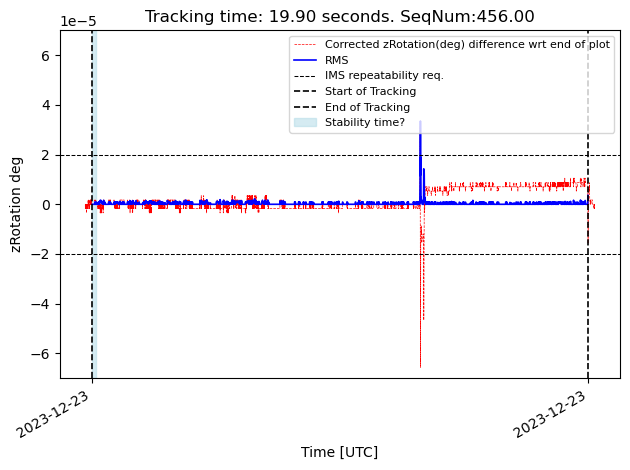

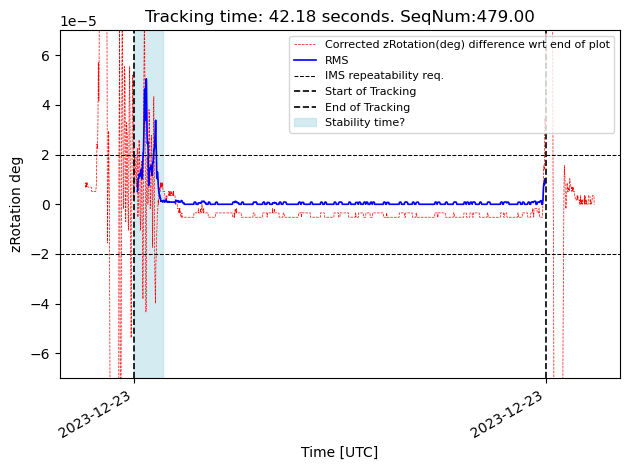

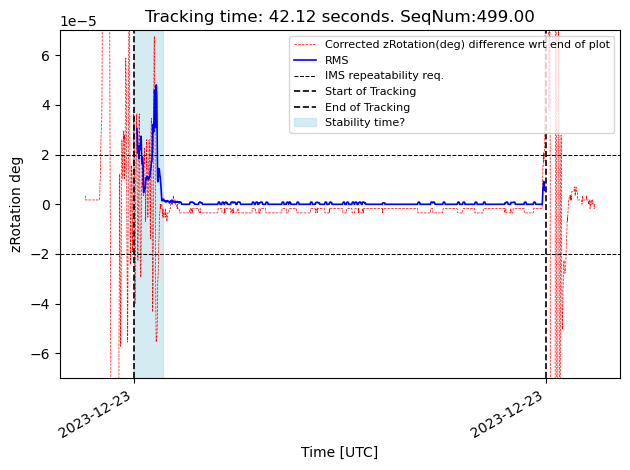

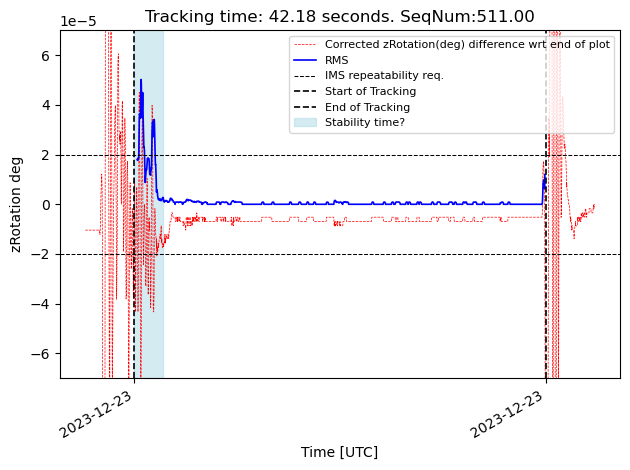

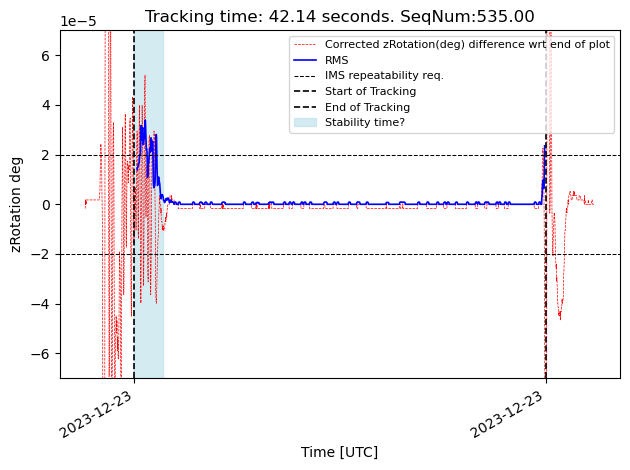

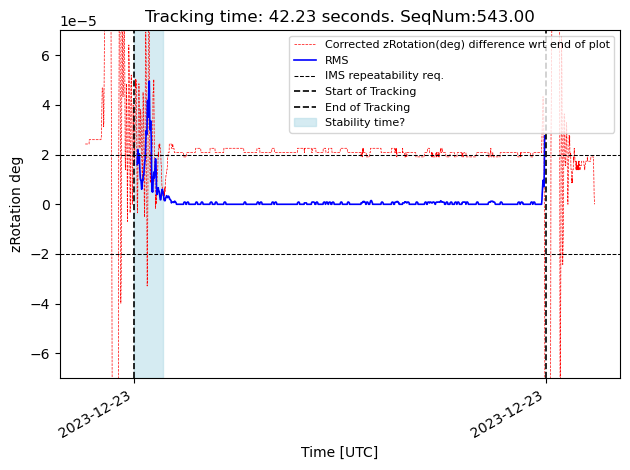

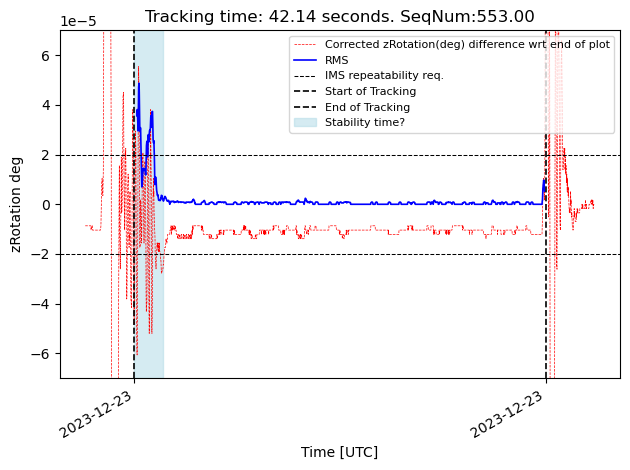

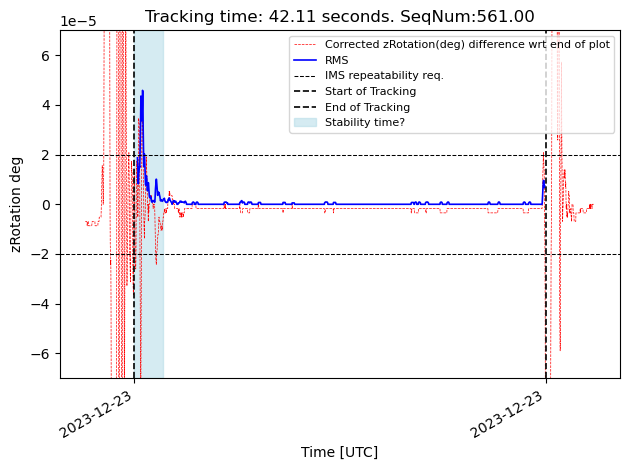

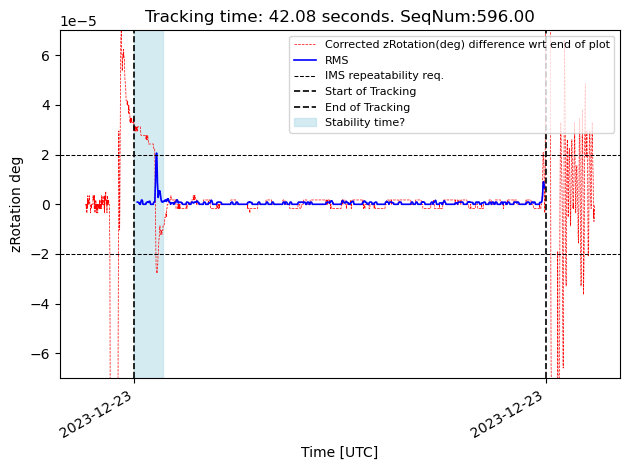

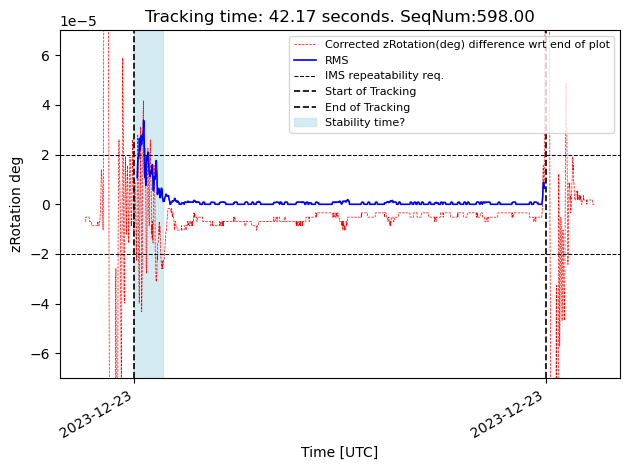

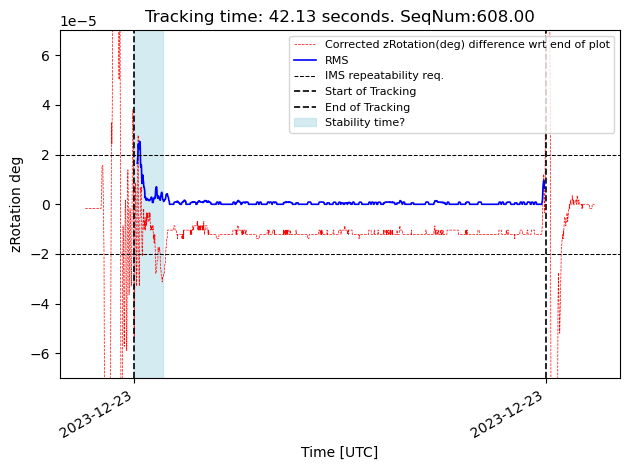

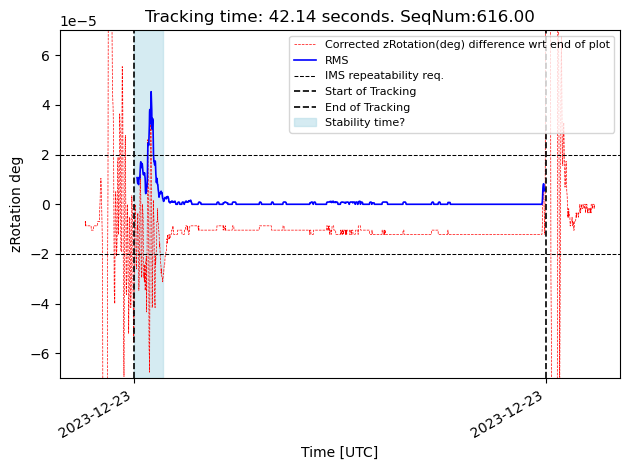

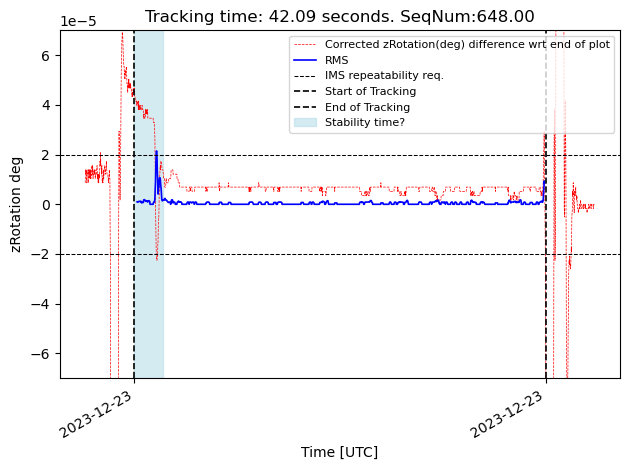

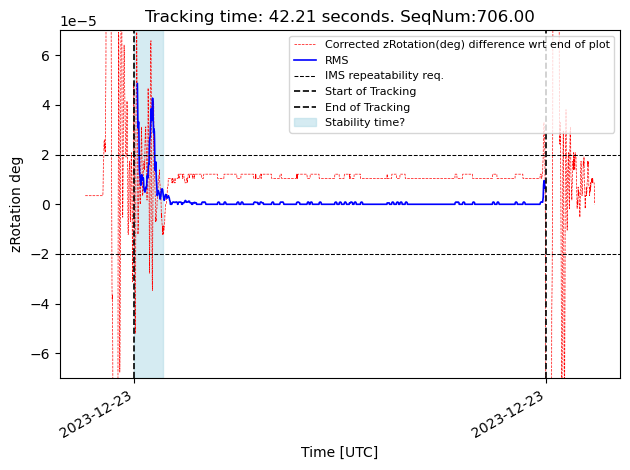

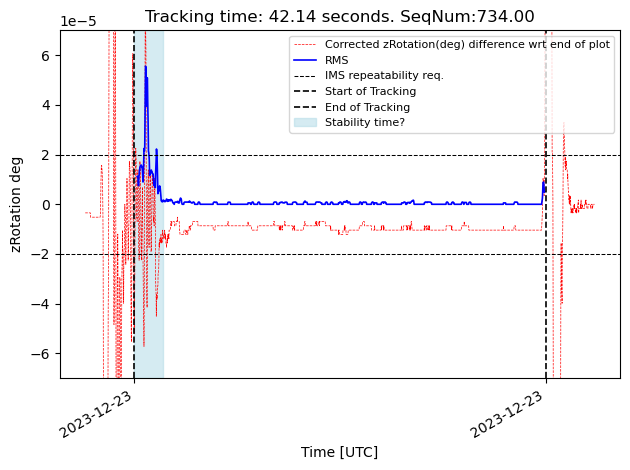

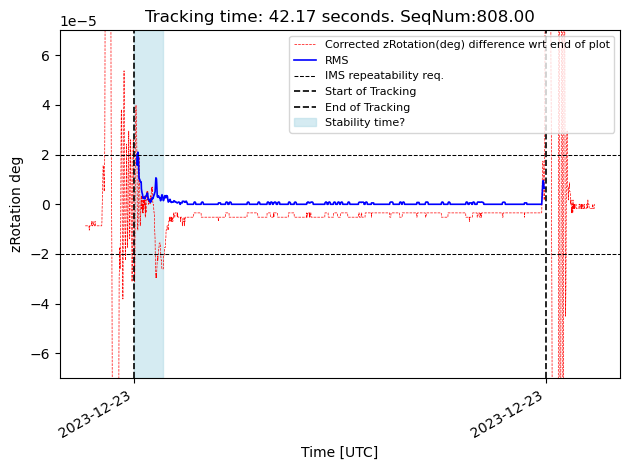

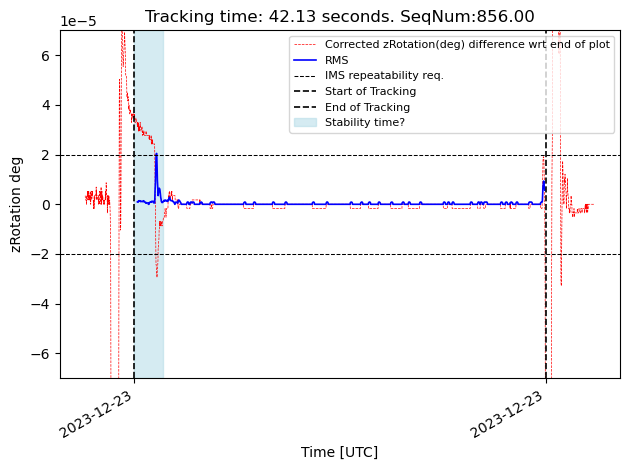

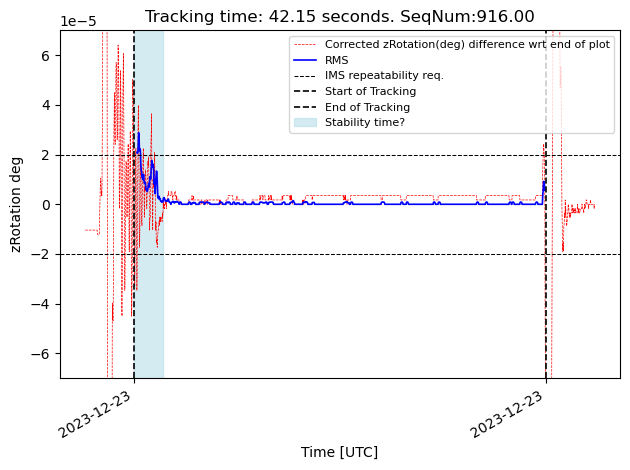

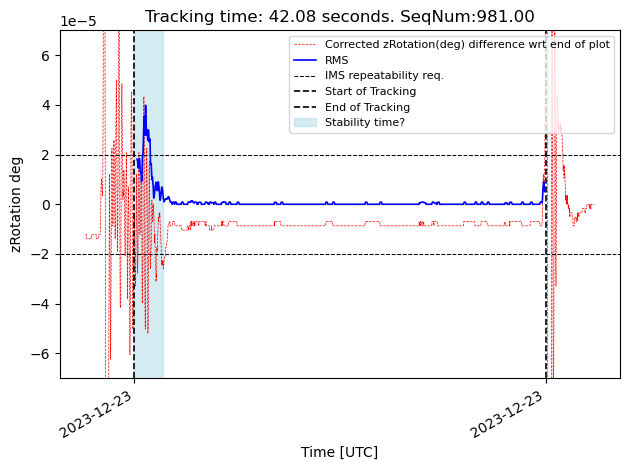

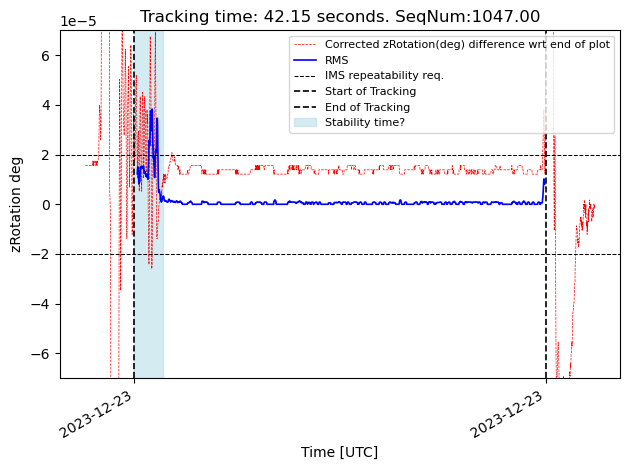

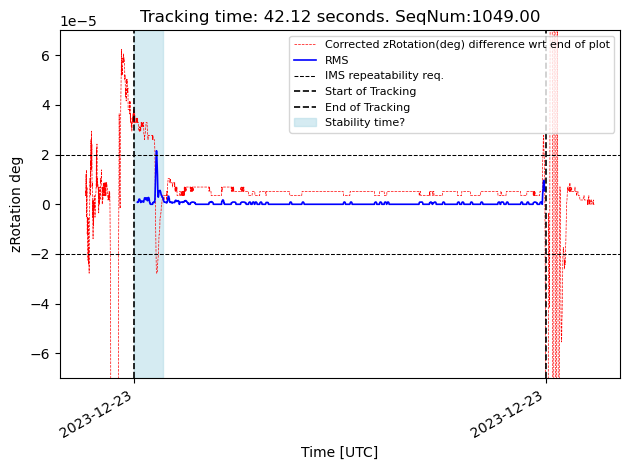

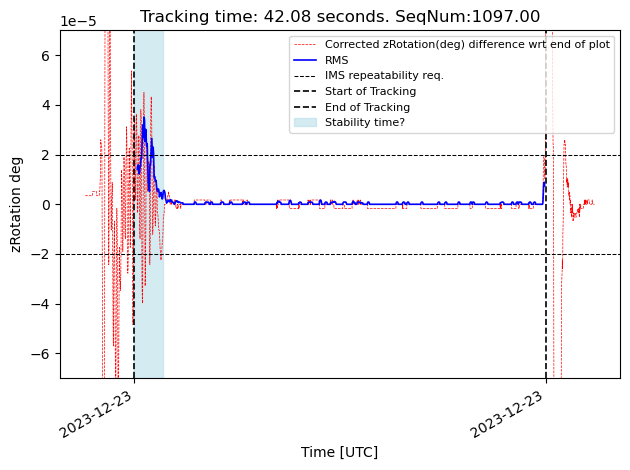

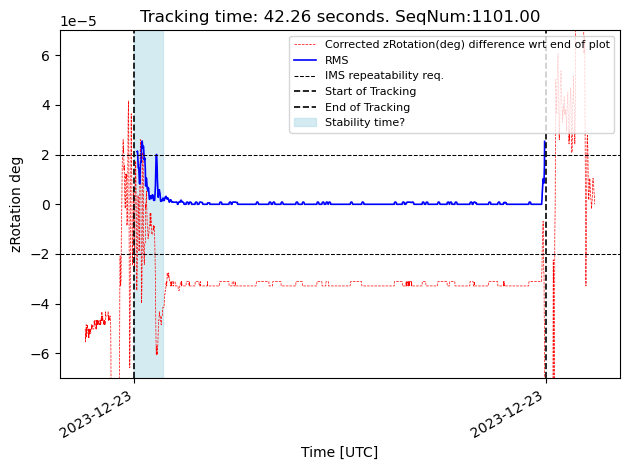

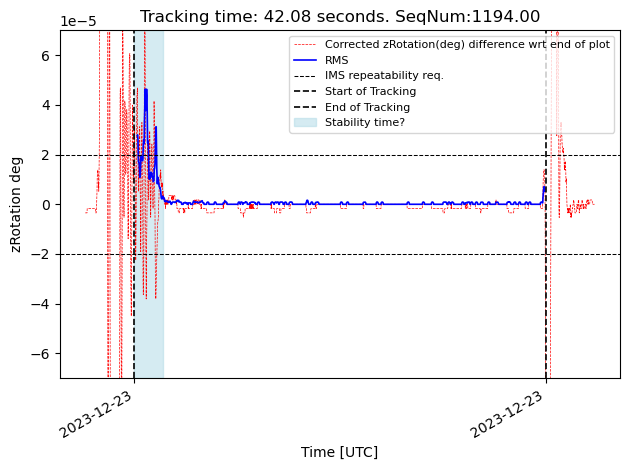

In [37]:
unstable_events = {}
outRMSLimits_event = []
for event in enumerate(tracks_block146):
    targetSeqNum = event[1].seqNum
    is_unstable = False
    unstable_reason = "stable"
    #print(targetSeqNum)
    for t, tl in enumerate(tracks):
        if tl.seqNum == targetSeqNum:
            #print("tracking number seq Num: ", targetSeqNum)
            i_track = t

            # Select the information during the tracking
            t0 = Time(tracks[i_track].begin, format="isot", scale="utc")
            t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
            t1 = Time(tracks[i_track].end, format="isot", scale="utc")
            t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
            #print("Tracking stop at:", t1)
            
            # Get IMS data
            df_ims = getEfdData(
                     client, "lsst.sal.MTM1M3.imsData", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
            df_ims = df_ims[all_columns]
            # Convert meter to milimeter
            df_ims[pos_columns] = df_ims[pos_columns] * 1e3
            
            #df_mtmount_ele = getEfdData(
            #client, "lsst.sal.MTMount.elevation", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

            #df_mtmount_azi = getEfdData(
            #client, "lsst.sal.MTMount.azimuth", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
            
            #stability throughout a tracking period
            %matplotlib inline
            
            settle_intervals = np.empty(6)
            c = 0.

            for col in all_columns:
                if col in pos_columns:
                   req = req_rms_position
                else:
                   req = req_rms_rotation

                Unstable = detectUnstableEvents(
                           df_ims=df_ims,
                           tt_start=t0,
                           tt_end=t1,        
                           imsColumn=col,
                           rmsReq=req,
                           delta_t=5
                           )
                
                if Unstable == -1:
                   is_unstable = True
                   unstable_reason = "sortTime"
                   break
                if Unstable == -2:
                   is_unstable = True
                   unstable_reason = "outRMSLimits"
                   outRMSLimits_event.append(targetSeqNum)
                   break

    unstable_events[targetSeqNum] = {"is_unstable": is_unstable, "reason": unstable_reason}  

    if unstable_reason == "outRMSLimits": #"outRMSLimits":
        
        for col in all_columns:
                if col in pos_columns:
                   req = req_rms_position
                else:
                   req = req_rms_rotation 
                    
                settle_interval = computeSettleTrack(
                   df_ims=df_ims,
                   tt_start=t0,
                   tt_end=t1,        
                   imsColumn=col,
                   rmsReq=req,
                   #req_delta_t=req_delta_t,
                   chi2prob=0.99,
                   delta_t=5,
                   seqNum=targetSeqNum
                   )   
                

In [ ]:
count_is_unstable = {"True": sum(event["is_unstable"] for event in unstable_events.values()),
               
                     "False": sum(not event["is_unstable"] for event in unstable_events.values())}
print(count_is_unstable)

In [ ]:
from collections import Counter
count_reason = [event["reason"] for event in unstable_events.values()]

print(Counter(count_reason))

In [ ]:
# Select stables events
stable_events = [key for key, value in unstable_events.items() if not value['is_unstable']]

print(stable_events)

In [ ]:
targetSeqNum = 910

for t, tl in enumerate(tracks):
    if tl.seqNum == targetSeqNum:
      i_track = t
        
print(f"Event with seqNum {targetSeqNum} corresponds to track number {i_track}")

t0 = Time(tracks[i_track].begin, format="isot", scale="utc")
t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
t1 = Time(tracks[i_track].end, format="isot", scale="utc")
t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion

#stability throughout a tracking period
%matplotlib inline

settle_intervals = np.empty(6)
c = 0.

for col in all_columns:
    print(col)
    if col in pos_columns:
        req = req_rms_position
    else:
        req = req_rms_rotation

    settle_interval = computeSettleTrack(
        df_ims=df_ims,
        tt_start=t0,
        tt_end=t1,        
        imsColumn=col,
        rmsReq=req,
        #req_delta_t=req_delta_t,
        chi2prob=0.99,
        delta_t=5
    )

In [ ]:
for eventNum in outRMSLimits_event:
    #targetSeqNum = event[1].seqNum
    #is_unstable = False
    unstable_reason = "unknown"
    for t, tl in enumerate(tracks):
        if tl.seqNum == eventNum:
            #print("tracking number seq Num: ", targetSeqNum)
            i_track = t

            # Select the information during the tracking
            t0 = Time(tracks[i_track].begin, format="isot", scale="utc")
            t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
            t1 = Time(tracks[i_track].end, format="isot", scale="utc")
            t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
            #print("Tracking stop at:", t1)
            
            # Get IMS data
            df_ims = getEfdData(
                     client, "lsst.sal.MTM1M3.imsData", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
            df_ims = df_ims[all_columns]
            # Convert meter to milimeter
            df_ims[pos_columns] = df_ims[pos_columns] * 1e3
            
            #df_mtmount_ele = getEfdData(
            #client, "lsst.sal.MTMount.elevation", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

            #df_mtmount_azi = getEfdData(
            #client, "lsst.sal.MTMount.azimuth", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
            
            #stability throughout a tracking period
            %matplotlib inline
            
            settle_intervals = np.empty(6)
            c = 0.

            for col in all_columns:
                if col in pos_columns:
                   req = req_rms_position
                else:
                   req = req_rms_rotation

                Reason = detectUnstableReason(
                           df_ims=df_ims,
                           tt_start=t0,
                           tt_end=t1,        
                           imsColumn=col,
                           rmsReq=req,
                           delta_t=5
                           )
                if Reason == -1:
     #              is_unstable = True
                   unstable_reason = "FirstSecond"
                   #break
                if Unstable == -2:
     #              is_unstable = True
                   unstable_reason = "unknown"
     #              outRMSLimits_event.append(targetSeqNum)
                   break

    unstable_events[eventNum]["reason_2"] = unstable_reason
    
    if unstable_reason == "unknown":
        for col in all_columns:
                if col in pos_columns:
                   req = req_rms_position
                else:
                   req = req_rms_rotation 
                    
                settle_interval = computeSettleTrack(
                   df_ims=df_ims,
                   tt_start=t0,
                   tt_end=t1,        
                   imsColumn=col,
                   rmsReq=req,
                   #req_delta_t=req_delta_t,
                   chi2prob=0.99,
                   delta_t=5,
                   seqNum=eventNum
                   )


In [ ]:
from collections import Counter
count_reason = [event["reason_2"] for event in unstable_events.values()]

print(Counter(count_reason))

In [ ]:
# Select a event of trancking in block 137
targetSeqNum = 552

In [ ]:
# find the appropriate tracking index that has the sequential number selected above
for t, tl in enumerate(tracks): 
    if tl.seqNum == targetSeqNum:
        i_track = t
        break
print(f"Event with seqNum {targetSeqNum} corresponds to track number {i_track}")

In [ ]:
tracks[i_track]

In [ ]:
# Select the information during the tracking
t0 = Time(tracks[i_track].begin, format="isot", scale="utc")
t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
t1 = Time(tracks[i_track].end, format="isot", scale="utc")
t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
print("Tracking stop at:", t1)

# Get IMS data
df_ims = getEfdData(
    client, "lsst.sal.MTM1M3.imsData", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
df_ims = df_ims[all_columns]
# Convert meter to milimeter
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

In [ ]:
df_mtmount_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

df_mtmount_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

### Look at data

In [ ]:
## Time of the tracking:

# Get durations of the tracking
durations = [track.duration for track in tracks_block137]

# Calculate mean, standard deviation, and variance
mean_duration = np.mean(durations)
standard_deviation = np.std(durations)
variance = np.var(durations)
median_duration = np.median(durations)

# Round the durations for mode calculation
rounded_durations = [round(track.duration) for track in tracks_block137]

# Calculate mode of rounded durations
mode_duration = stats.mode(rounded_durations)


# Print the results
print("Number of trackings:", len(durations))
print("Mean duration of tracking:", mean_duration)
print("Median duration of tracking:", median_duration)
print("Mode of tracking duration (rounded):", mode_duration.mode[0])
print("Standard deviation of tracking duration:", standard_deviation)
print("Variance of tracking duration:", variance)
print("Maximum duration of tracking:", np.max(durations))
print("Minimum duration of tracking:", np.min(durations))


# Create a boxplot using seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(y=durations, width=0.5)
plt.title('Boxplot of Tracking Duration')
plt.ylabel('Duration (s)')
plt.show()

# Create a boxplot using seaborn (zoom)
plt.figure(figsize=(8, 6))
sns.boxplot(y=durations, width=0.5)
plt.ylim(np.percentile(durations, 7), np.percentile(durations, 93))
plt.title('Zoomed Boxplot of Tracking Duration')
plt.ylabel('Duration (s)')
plt.show()


In [ ]:
# Create a histogram using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(durations, bins=20, kde=True)
plt.title('Histogram of Tracking Duration')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

In [ ]:
%matplotlib inline
compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    t0,
    t1,
    delta_t
)

## Stability tracking period

In [ ]:
#stability throughout a tracking period
%matplotlib inline

settle_intervals = np.empty(6)
c = 0.

for col in all_columns:
    print(col)
    if col in pos_columns:
        req = req_rms_position
    else:
        req = req_rms_rotation

    settle_interval = computeSettleTrack(
        df_ims=df_ims,
        tt_start=t0,
        tt_end=t1,        
        imsColumn=col,
        rmsReq=req,
        #req_delta_t=req_delta_t,
        chi2prob=0.99,
        delta_t=5
    )